# InstaCart Market Basket Analysis

This Code is the first attempt at a Kaggle Competition

Objective: predict if a user will reorder items and what items they would reorder




### Data description (provided)

The dataset for this competition is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. 


### Submission file

For each order_id in the test set, you should predict a space-delimited list of product_ids for that order. If you wish to predict an empty order, you should submit an explicit 'None' value. You may combine 'None' with product_ids. The spelling of 'None' is case sensitive in the scoring metric. The file should have a header and look like the following:

order_id,products  
17,1 2  
34,None  
137,1 2 3  
etc.
##### Submission are evaluated on Mean F1 Score

In [2]:
# Import packages as I need them
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color = sns.color_palette()

#set format rules
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))


In [3]:
# Import datasets
input = "/Users/austinbell/Documents/KComps/InstaCart"
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
orders_priors = pd.read_csv("order_products__prior.csv")
orders_train = pd.read_csv("order_products__train.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

In [92]:
#Start exploring
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [93]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [9]:
orders_priors.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [10]:
orders_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [11]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [12]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [14]:
print("Order Df has", len(orders),
     "Orders_priors DF has", len(orders_priors),
     "Orders_train DF has", len(orders_train))

Order Df has 3421083 Orders_priors DF has 32434489 Orders_train DF has 1384617


<function matplotlib.pyplot.show>

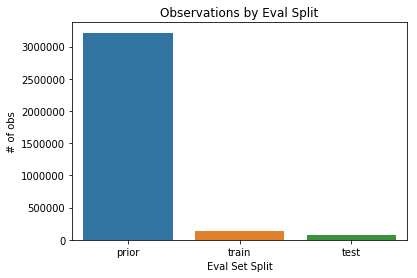

In [4]:
#Orders has three eval_sets - lets see the split via a bar graph
count_order_sets = orders.eval_set.value_counts()
count_order_sets

bar = sns.barplot(x = count_order_sets.index, y = count_order_sets.values)
bar.set(xlabel = "Eval Set Split", ylabel = "# of obs", title = "Observations by Eval Split")
plt.show

In [97]:
orders_test = orders[orders['eval_set'] == 'test']
orders_df = orders[orders['eval_set'] != 'test']

orders_total = (orders_priors.append(orders_train)
                .merge(products, left_on = 'product_id', right_on = 'product_id',how = 'left')
                .merge(aisles, left_on = 'aisle_id', right_on = 'aisle_id', how = 'left')
                .merge(departments, left_on = 'department_id', right_on = 'department_id', how = 'left')
                .merge(orders_df, on = 'order_id', how = 'left'))


In [39]:
orders_total.head()

,order_id,product_id,add_to_cart_order,reordered,eval_set_x,product_name,aisle_id,department_id,aisle,department,user_id,eval_set_y,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,prior,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,prior,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,prior,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,prior,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,prior,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [49]:
# frequency tables of items that appear with reordered ratio ordered by frequency and reordered ratio
def get_frequency(data, column):
    
    reordered = data.groupby(column)['reordered'].mean().reset_index()
    reordered.columns = [column, 'ratio']
    frequency = data[column].value_counts().reset_index()
    frequency.columns = [column, 'counts']
    frequency = frequency.merge(reordered, on = column, how = 'left')
    
    return frequency 

frequency_prod = get_frequency(orders_total, 'product_name')
display(frequency_prod.head(30))
display(frequency_prod[frequency_prod['counts'] > 1000].sort_values(by = 'ratio', ascending = False).head(30))

,product_name,counts,reordered,ratio
0,Banana,491291,415166,0.845051
1,Bag of Organic Bananas,394930,329275,0.833755
2,Organic Strawberries,275577,214448,0.778178
3,Organic Baby Spinach,251705,194939,0.774474
4,Organic Hass Avocado,220877,176173,0.797607
5,Organic Avocado,184224,140270,0.761410
6,Large Lemon,160792,112178,0.697659
7,Strawberries,149445,104588,0.699843
8,Limes,146660,100002,0.681863
9,Organic Whole Milk,142813,118684,0.831045


,product_name,counts,reordered,ratio
1976,Half And Half Ultra Pasteurized,2995,2580,0.861436
537,Whole Organic Omega 3 Milk,9410,8091,0.859830
592,Organic Lactose Free Whole Milk,8742,7511,0.859186
1457,Organic Homogenized Whole Milk,4095,3514,0.858120
3674,Ultra-Purified Water,1524,1306,0.856955
187,"Milk, Organic, Vitamin D",20770,17753,0.854742
92,Organic Reduced Fat Milk,36869,31394,0.851501
1062,Goat Milk,5353,4551,0.850177
0,Banana,491291,415166,0.845051
279,Organic Lowfat 1% Milk,15352,12914,0.841193


In [99]:
# Least likely to be ordered and reordered
display(frequency_prod.sort_values(by = 'counts').head(30))
display(frequency_prod[frequency_prod['counts'] > 1000].sort_values(by = 'ratio').head(30))

,product_name,counts,reordered,ratio
49684,Mustard & Onion,1,0,0.0
49609,Bottle & Nipple Brush Set,1,0,0.0
49610,"Salsa, Black Bean",1,0,0.0
49611,Vitamin D Gummies,1,0,0.0
49612,7.04 Oz. Grahamfuls Banana Vanilla 8ct,1,0,0.0
49613,"Frittata, Farmer's Market",1,0,0.0
49614,Organic Better Rest Tea Blend,1,0,0.0
49615,Imported Stout Draught Style,1,0,0.0
49616,'Swingtop' Premium Lager,1,0,0.0
49617,Ultra Sun Blossom Liquid 90 loads Fabric Enhan...,1,0,0.0


,product_name,counts,reordered,ratio
4883,Organic Ground Nutmeg,1088,38,0.034926
5010,Cumin Seed,1055,57,0.054028
3240,Ground Ginger,1785,105,0.058824
3287,Cayenne Pepper,1755,112,0.063818
3016,Corn Starch,1921,140,0.072879
4428,100% Pure Corn Starch,1234,92,0.074554
1990,Paprika,2975,229,0.076975
1951,Bay Leaves,3034,234,0.077126
2841,Sesame Seed,2053,162,0.078909
4772,Seasoning Bay Leaf,1119,91,0.081323


In [100]:
#Similar tables for departments and aisles
frequency_dept = get_frequency(orders_total, 'department')

display(frequency_dept)
display(frequency_dept[frequency_dept['counts'] > 1000].sort_values(by = 'ratio', ascending = False))


,department,counts,reordered,ratio
0,produce,9888378,6432596,0.650521
1,dairy eggs,5631067,3773723,0.670161
2,snacks,3006412,1727075,0.574464
3,beverages,2804175,1832952,0.653651
4,frozen,2336858,1268058,0.542634
5,pantry,1956819,679799,0.347400
6,bakery,1225181,769880,0.628381
7,canned goods,1114857,511317,0.458639
8,deli,1095540,666231,0.608130
9,dry goods pasta,905340,418466,0.462220


,department,counts,reordered,ratio
1,dairy eggs,5631067,3773723,0.670161
3,beverages,2804175,1832952,0.653651
0,produce,9888378,6432596,0.650521
6,bakery,1225181,769880,0.628381
8,deli,1095540,666231,0.608130
17,pets,102221,61594,0.602557
14,babies,438743,253453,0.577680
20,bulk,35932,20736,0.577090
2,snacks,3006412,1727075,0.574464
16,alcohol,159294,90992,0.571221


In [103]:
frequency_aisle = get_frequency(orders_total, 'aisle')

display(frequency_aisle.head(30))
display(frequency_aisle[frequency_aisle['counts'] > 1000].sort_values(by = 'ratio', ascending = False).head(30))

,aisle,counts,reordered,ratio
0,fresh fruits,3792661,2726251,0.718823
1,fresh vegetables,3568630,2123540,0.595057
2,packaged vegetables fruits,1843806,1178700,0.639275
3,yogurt,1507583,1034957,0.686501
4,packaged cheese,1021462,598280,0.585710
5,milk,923659,722128,0.781812
6,water seltzer sparkling water,878150,640988,0.729930
7,chips pretzels,753739,444036,0.589111
8,soy lactosefree,664493,460069,0.692361
9,bread,608469,408010,0.670552


,aisle,counts,reordered,ratio
5,milk,923659,722128,0.781812
6,water seltzer sparkling water,878150,640988,0.729930
0,fresh fruits,3792661,2726251,0.718823
15,eggs,472009,333408,0.706359
8,soy lactosefree,664493,460069,0.692361
33,packaged produce,289488,200319,0.691977
3,yogurt,1507583,1034957,0.686501
26,cream,330358,226356,0.685184
9,bread,608469,408010,0.670552
10,refrigerated,599109,397213,0.663006


In [102]:
display(frequency_aisle.sort_values(by = 'counts').head(30))
display(frequency_aisle[frequency_aisle['counts'] > 1000].sort_values(by = 'ratio').head(30))

,aisle,counts,reordered,ratio
133,frozen juice,5147,2327,0.452108
132,beauty,6455,1374,0.212858
131,baby accessories,8466,4669,0.551500
130,baby bath body care,8909,2626,0.294758
129,eye ear care,9522,2100,0.220542
128,kitchen supplies,9620,1874,0.194802
127,skin care,10698,2598,0.242849
126,shave needs,10876,2864,0.263332
125,first aid,11411,2235,0.195864
124,specialty wines champagnes,11659,5681,0.487263


,aisle,counts,reordered,ratio
45,spices seasonings,221371,33855,0.152933
108,baking supplies decor,24786,4154,0.167595
128,kitchen supplies,9620,1874,0.194802
125,first aid,11411,2235,0.195864
132,beauty,6455,1374,0.212858
129,eye ear care,9522,2100,0.220542
106,cold flu allergy,27407,6450,0.235341
120,deodorants,15673,3743,0.238818
127,skin care,10698,2598,0.242849
101,hair care,33482,8262,0.246759


<function matplotlib.pyplot.show>

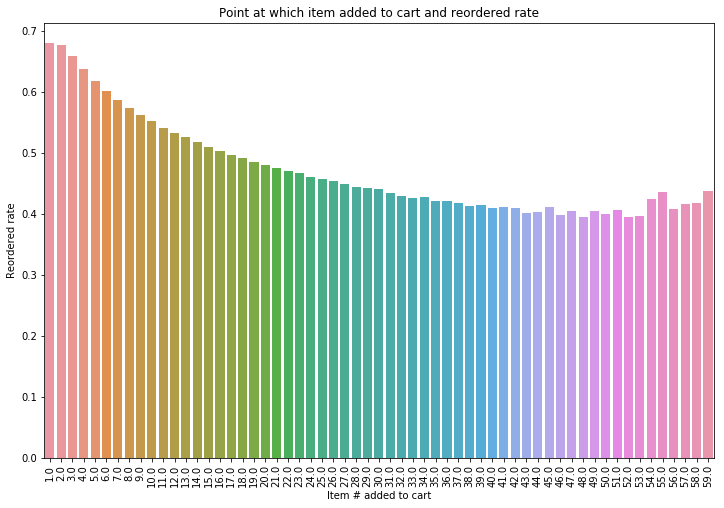

In [144]:
num_items = get_frequency('add_to_cart_order')
plt.figure(figsize = (12,8))
items_plt = sns.barplot(x = num_items['add_to_cart_order'].where(num_items['counts'] > 1000), y = num_items['ratio'])
items_plt.set(xlabel = 'Item # added to cart', ylabel = 'Reordered rate', 
              title = 'Point at which item added to cart and reordered rate')
plt.xticks(rotation = "vertical")
plt.show

#Strong relationship between when item is added to cart and how often it is reorded


In [57]:
max_items = orders_total.groupby('order_id')['add_to_cart_order'].max().reset_index()
max_items.columns = ['order_id', 'num_items']
max_items.describe()
#on average a couple items are ordered
#some big outliers
#average order size is 10


,order_id,num_items
count,3.346083e+06,3.346083e+06
mean,1.710561e+06,1.010707e+01
std,9.875758e+05,7.542326e+00
min,1.000000e+00,1.000000e+00
25%,8.552595e+05,5.000000e+00
50%,1.710552e+06,8.000000e+00
75%,2.565877e+06,1.400000e+01
max,3.421083e+06,1.450000e+02


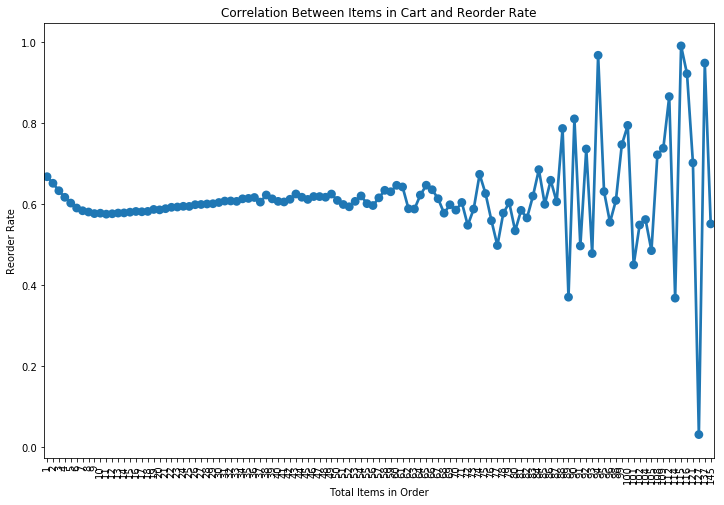

In [79]:
#lets calculate reorder rates for each order ID and determine if any relation exists between num items and reorder
max_items_reorder = orders_total.groupby('order_id')['reordered'].mean().reset_index()
max_items_reorder.columns = ['order_id', 'ratio']
max_items_ratio = max_items.merge(max_items_reorder, on = 'order_id', how = 'left')


#now group by num_items and average the ratio
ratio_num_items = max_items_ratio.groupby('num_items')['ratio'].mean()

plt.figure(figsize = (12,8))
plot = sns.pointplot(x = ratio_num_items.index, y = ratio_num_items.values)
plot.set(xlabel = 'Total Items in Order', ylabel = 'Reorder Rate', 
         title = 'Correlation Between Items in Cart and Reorder Rate')
plt.xticks(rotation = 'vertical')
plot

#Not as interesting as I would have hoped.
#However, it does show that when someone orders just one or two items then they are more likely to reorder those items

<function matplotlib.pyplot.show>

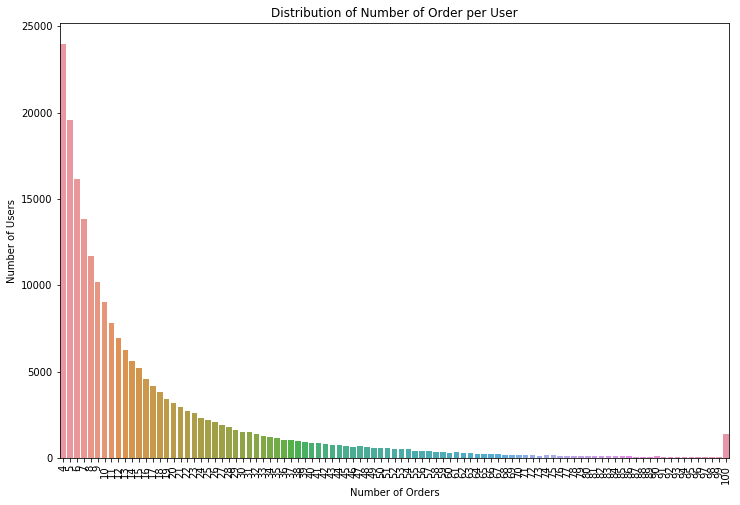

In [22]:
#Verify the 4 to 100 orders by user
orders_by_user = orders.groupby('user_id')['order_number'].aggregate(np.max).reset_index()

dist_of_num_orders = orders_by_user.groupby('order_number').count().reset_index().sort_values(by = 'order_number')
dist_of_num_orders.columns = ['num_orders', 'num_users']

plt.figure(figsize = (12,8))
orders_by_user_graph = sns.barplot(x = dist_of_num_orders['num_orders'], y = dist_of_num_orders['num_users'])
orders_by_user_graph.set(xlabel = 'Number of Orders', ylabel = 'Number of Users', 
                         title = 'Distribution of Number of Order per User')
plt.xticks(rotation = 'vertical')
plt.show
#as expected, a large portion are users with just a few orders
#the sudden jump at 100 is odd and might warrant further investigation

In [65]:
user_id_100_list = np.unique(orders_total[orders_total['order_number']==100]['user_id']).tolist()
user_id_100 = orders_total[orders_total['user_id'].isin(user_id_100_list)].sort_values(by = ['user_id', 'order_number'])
user_id_100_frequency = get_frequency(user_id_100, 'aisle')

display(user_id_100_frequency.head(30))
display(user_id_100_frequency[user_id_100_frequency['counts'] > 1000].sort_values(by = 'ratio', ascending = False).head(30))

#Much higher reorder rate as expected - Maybe, they have set for automatic delivery
#Anyways, a higher reorder rate for consistent users is not surprising
#someone who uses instacart for 100 orders does their routine shopping via instacart
#There is still a question of why the uptick at 100 though, but honestly it could be that Instacart just cut it off 

,aisle,counts,reordered,ratio
0,fresh fruits,96281,83871,0.871106
1,fresh vegetables,79450,62426,0.785727
2,packaged vegetables fruits,41107,33691,0.819593
3,yogurt,38166,32742,0.857884
4,milk,25935,23712,0.914286
5,water seltzer sparkling water,21862,19522,0.892965
6,packaged cheese,20664,16146,0.781359
7,soy lactosefree,17205,14830,0.861959
8,refrigerated,14900,12390,0.831544
9,bread,14103,11781,0.835354


,aisle,counts,reordered,ratio
4,milk,25935,23712,0.914286
5,water seltzer sparkling water,21862,19522,0.892965
34,packaged produce,5566,4891,0.878728
17,eggs,8983,7831,0.871758
0,fresh fruits,96281,83871,0.871106
7,soy lactosefree,17205,14830,0.861959
18,cream,8827,7603,0.861335
3,yogurt,38166,32742,0.857884
58,energy sports drinks,2491,2091,0.839422
9,bread,14103,11781,0.835354


<function matplotlib.pyplot.show>

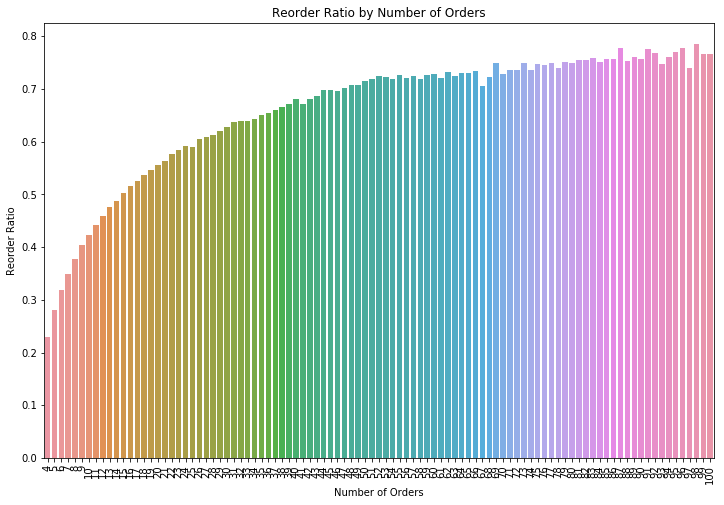

In [71]:
#Lets dive into this higher reorder rate for users with more orders
reorders_by_user = get_frequency(orders_total, 'user_id')
reorders_num_orders = (pd.merge(reorders_by_user, orders_by_user, on = 'user_id')
                       .groupby('order_number')['ratio'].mean()
                       .reset_index())
reorders_num_orders.columns = ['num_orders', 'ratio']
reorders_num_orders = reorders_num_orders.sort_values(by = 'num_orders')


plt.figure(figsize = (12,8))
reorders_num_orders_chart = sns.barplot(x = reorders_num_orders['num_orders'], y = reorders_num_orders['ratio'])
reorders_num_orders_chart.set(xlabel = 'Number of Orders', ylabel = "Reorder Ratio", 
                             title = "Reorder Ratio by Number of Orders")
plt.xticks(rotation = 'vertical')
plt.show

#Very substantial effect. Will likely be a very strong feature in the model

<function matplotlib.pyplot.show>

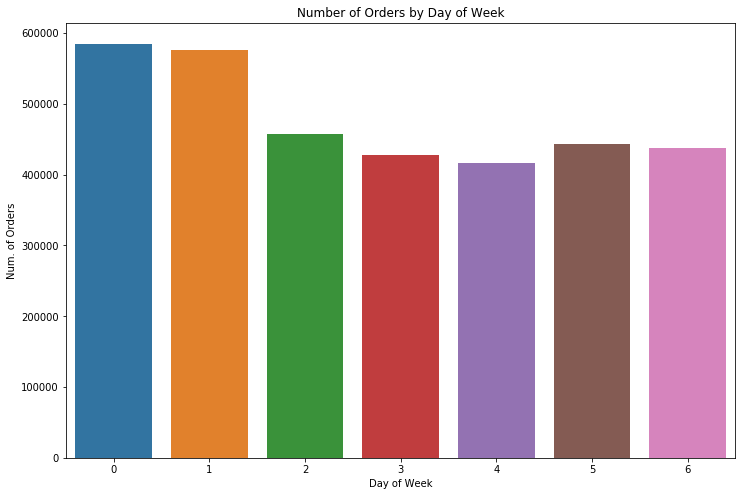

In [47]:
#Lets see how day of the week plays out
plt.figure(figsize = (12,8))
dow_freq = orders_df.groupby('order_dow').count().reset_index()
dow_freq_chart = sns.barplot(x = dow_freq['order_dow'], y = dow_freq['order_number'])
dow_freq_chart.set(xlabel = 'Day of Week', ylabel = 'Num. of Orders', title = "Number of Orders by Day of Week")
plt.show
#Assuming that Sunday = 0, Sunday and Monday are the dates with higher orders
#Do these dates also have a high reorder rate?

<function matplotlib.pyplot.show>

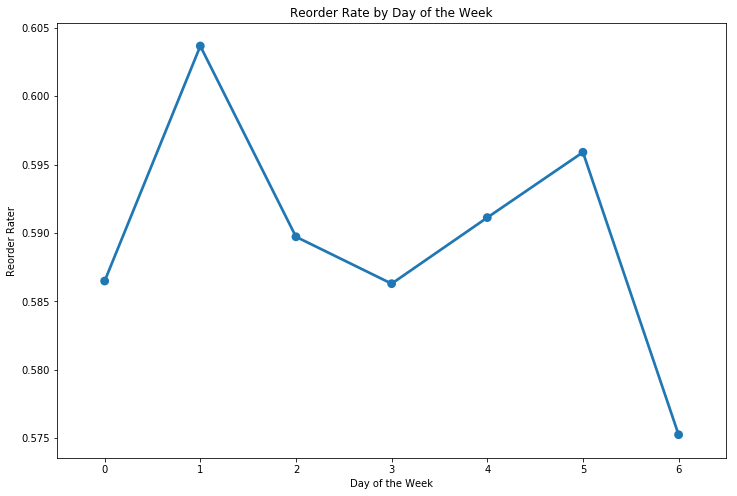

In [52]:
#However, does the middle of the week lead to a higher reorder rate? 
#Are people feeling more spontaneous during the weekend?

dow_reorder_rate = get_frequency(orders_total, 'order_dow')

plt.figure(figsize=(12,8))
dow_reorder_rate_chart = sns.pointplot(x = dow_reorder_rate['order_dow'], y = dow_reorder_rate['ratio'])
dow_reorder_rate_chart.set(xlabel = "Day of the Week", ylabel = "Reorder Rater", 
                           title = "Reorder Rate by Day of the Week")
plt.show

#Slightly higher on Monday, could be explained by routine shopping and spontaneity on the weekends

<function matplotlib.pyplot.show>

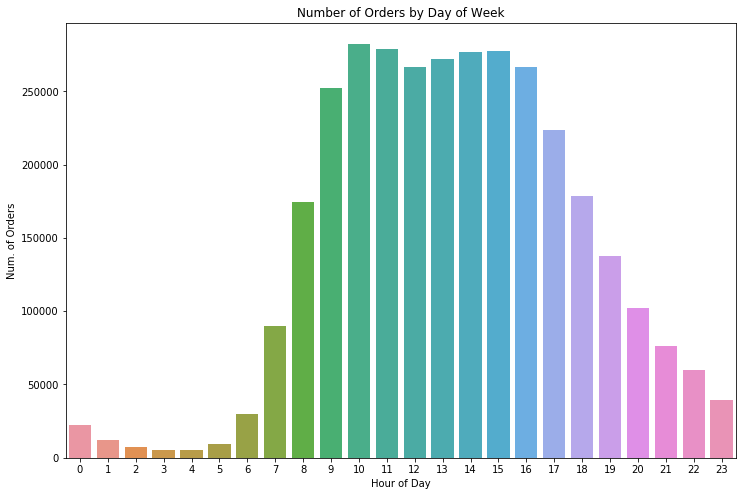

In [72]:
#Let's do the same thing for hour of the day.

plt.figure(figsize = (12,8))
dow_freq = orders_df.groupby('order_hour_of_day').count().reset_index()
dow_freq_chart = sns.barplot(x = dow_freq['order_hour_of_day'], y = dow_freq['order_number'])
dow_freq_chart.set(xlabel = 'Hour of Day', ylabel = 'Num. of Orders', title = "Number of Orders by Day of Week")
plt.show

#Lines up with Sleep cycles - nothing new here

<function matplotlib.pyplot.show>

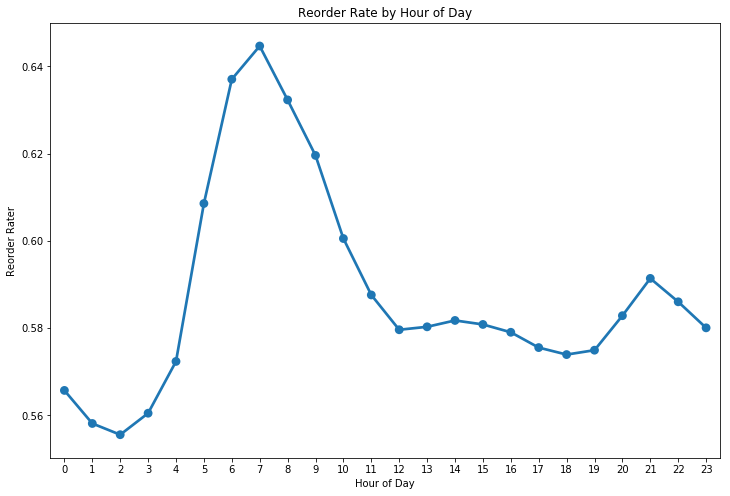

In [73]:
dow_reorder_rate = get_frequency(orders_total, 'order_hour_of_day')

plt.figure(figsize=(12,8))
dow_reorder_rate_chart = sns.pointplot(x = dow_reorder_rate['order_hour_of_day'], y = dow_reorder_rate['ratio'])
dow_reorder_rate_chart.set(xlabel = "Hour of Day", ylabel = "Reorder Rater", 
                           title = "Reorder Rate by Hour of Day")
plt.show

#Early hours lead to higher reorder rate.  Again, makes me think of people setting automatic timers or a routine
#E.g., Monday at 6am purchase milk 

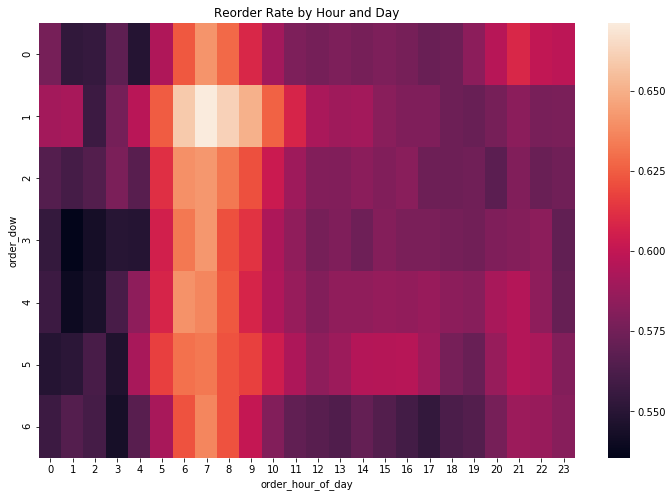

In [81]:
#A Heatmap of hour vs. day with colors representing reorder rate should provide more evidence
dow_hour_reordered = orders_total.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
dow_hour_reordered = dow_hour_reordered.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,8))
sns.heatmap(dow_hour_reordered)
plt.title("Reorder Rate by Hour and Day")
plt.show()

#Brighter colors during waking hours. However, the brightest color is Monday
    #Provides more evidence for automatic timers or a routine

<function matplotlib.pyplot.show>

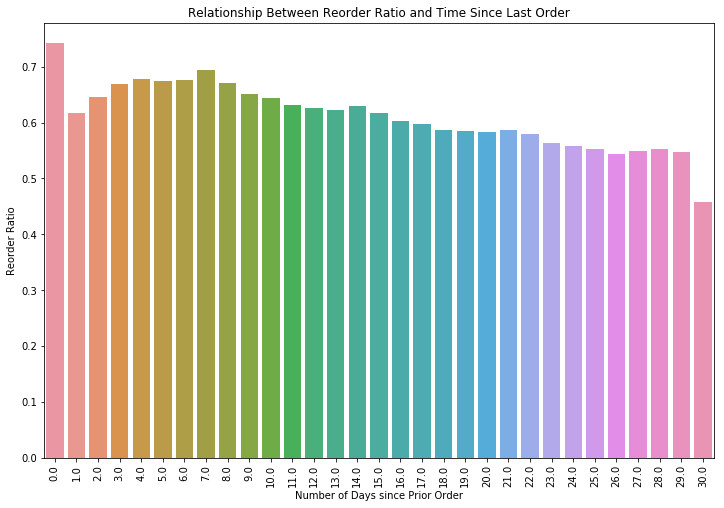

In [86]:
#Finally, does number of days since last order play a role?
#My guess is yes. A consistent/few days between purchases suggest that they use instacart for every day shopping
#They would constantly need to buy their necessities

days_since_prior_order = get_frequency(orders_total, 'days_since_prior_order')

plt.figure(figsize = (12,8))
days_since_prior_order_chart = sns.barplot(x = days_since_prior_order['days_since_prior_order'],
                                           y = days_since_prior_order['ratio'])
days_since_prior_order_chart.set(xlabel = "Number of Days since Prior Order", ylabel = "Reorder Ratio",
                          title = "Relationship Between Reorder Ratio and Time Since Last Order")
plt.xticks(rotation = 'vertical')
plt.show
#As expected higher reorder ratio for less days in between
#After zero, peak is at 7 which suggests weekly routine

In [87]:
#The high reorder rate at zero raises some questions though
zero_counts = days_since_prior_order[days_since_prior_order['days_since_prior_order'] == 0]
zero_counts
#High frequency so not outliers

,days_since_prior_order,counts,reordered,ratio
18,0.0,465742,345527,0.741885


In [88]:
zero_days = orders_total[orders_total['days_since_prior_order'] == 0]
zero_days.head(200)

,order_id,product_id,add_to_cart_order,reordered,eval_set_x,product_name,aisle_id,department_id,aisle,department,user_id,eval_set_y,order_number,order_dow,order_hour_of_day,days_since_prior_order
216,24,40078,1,0,prior,Strawberry Lemonade Frozen Pops,37,1,ice cream ice,frozen,193635,prior,19,0,14,0.0
217,24,9065,2,0,prior,Mint Chocolate Cookie Ice Cream,37,1,ice cream ice,frozen,193635,prior,19,0,14,0.0
218,24,46175,3,0,prior,Half Baked® Ice Cream,37,1,ice cream ice,frozen,193635,prior,19,0,14,0.0
359,45,16349,1,1,prior,Organic Yams,83,4,fresh vegetables,produce,37913,prior,55,1,14,0.0
602,73,28413,1,0,prior,Bunny-Luv Organic Carrots,83,4,fresh vegetables,produce,152590,prior,13,0,12,0.0
603,73,24125,2,1,prior,Olive Bread,112,3,bread,bakery,152590,prior,13,0,12,0.0
604,73,11759,3,1,prior,Organic Simply Naked Pita Chips,107,19,chips pretzels,snacks,152590,prior,13,0,12,0.0
605,73,21903,4,1,prior,Organic Baby Spinach,123,4,packaged vegetables fruits,produce,152590,prior,13,0,12,0.0
1042,116,27104,1,1,prior,Fresh Cauliflower,83,4,fresh vegetables,produce,119087,prior,25,6,18,0.0
1043,116,42342,2,1,prior,Roasted Turkey Breast,96,20,lunch meat,deli,119087,prior,25,6,18,0.0


In [91]:
zero_days_aisles = get_frequency(zero_days, 'aisle')
zero_days_aisles
#Dominated by fruits and vegetables and other foods that can go bad
#having an order with zero days in between could imply that the user is more likely to use instacart
#for all of their shopping needs. 

,aisle,counts,reordered,ratio
0,fresh fruits,50245,42602,0.847885
1,fresh vegetables,46074,36097,0.783457
2,packaged vegetables fruits,23431,18753,0.800350
3,yogurt,19242,15896,0.826110
4,water seltzer sparkling water,14167,11666,0.823463
5,packaged cheese,12053,8779,0.728366
6,milk,11547,10089,0.873733
7,chips pretzels,10863,7757,0.714075
8,soy lactosefree,9547,7897,0.827171
9,refrigerated,8586,6538,0.761472


In [98]:
#Save Datasets for later use
orders_total.to_csv("Orders Total.csv")